# Create Graph

Data is from paper "[Immune Landscape of Viral- and Carcinogen-Driven Head and Neck Cancer](https://europepmc.org/article/MED/31924475)" by Cillo et al.

TODO: Docstring

## Load Packages, Data

In [1]:
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
import scipy.sparse as sparse
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import GmGM
import math

In [2]:
# Load the data in backed mode
adata = ad.read_h5ad("out/E-GEOD-139324.h5ad", backed=True)
adata

AnnData object with n_obs × n_vars = 25184 × 157689 backed at 'out/E-GEOD-139324.h5ad'

In [3]:
# Add cell id/gene name annotations
adata.obs_names = pd.read_csv(
    "data/E-GEOD-139324-quantification-raw-files/E-GEOD-139324.aggregated_filtered_counts.mtx_rows",
    sep="\t",
    header=None
)[0]
adata.var_names = pd.read_csv(
    "data/E-GEOD-139324-quantification-raw-files/E-GEOD-139324.aggregated_filtered_counts.mtx_cols",
    sep="\t",
    header=None
)[0]
adata

AnnData object with n_obs × n_vars = 25184 × 157689 backed at 'out/E-GEOD-139324.h5ad'

In [4]:
# Load metadata
metadata = pd.read_csv("./data/ExpDesign-E-GEOD-139324.tsv", sep="\t", index_col="Assay")
print(list(metadata.columns))

# Add metadata
adata.var["individual"] = metadata.loc[adata.var_names, "Sample Characteristic[individual]"].astype("category")
adata.var["disease"] = metadata.loc[adata.var_names, "Factor Value[disease]"].astype("category")
adata.var["infection"] = metadata.loc[adata.var_names, "Factor Value[infection]"].astype("category")
adata.var["organism_part"] = metadata.loc[adata.var_names, "Factor Value[organism part]"].astype("category")
adata

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_33775/3027902069.py:2: DtypeWarning: Columns (14,18,28) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("./data/ExpDesign-E-GEOD-139324.tsv", sep="\t", index_col="Assay")


['Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[ethnic group]', 'Sample Characteristic Ontology Term[ethnic group]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[infection]', 'Sample Characteristic Ontology Term[infection]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[tumor grading]', 'Sample Characteristic Ontology Term[tumor grading]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[cell type]', 'Sample Characteristic Ontology Term[cell type]', 'Sample Characteristic[immunophenotype]', 'Sample C

AnnData object with n_obs × n_vars = 25184 × 157689 backed at 'out/E-GEOD-139324.h5ad'
    var: 'individual', 'disease', 'infection', 'organism_part'

In [5]:
# Load clustering produced by the paper
paper_clusters = pd.read_csv("./data/E-GEOD-139324.clusters.tsv", sep="\t")
paper_clusters

,sel.K,K,SRR10340945-AAACCTGAGGAGCGTT,SRR10340945-AAACCTGCACGGACAA,SRR10340945-AAACCTGCAGAAGCAC,SRR10340945-AAACCTGCAGATGAGC,SRR10340945-AAACCTGGTCTCCCTA,SRR10340945-AAACGGGAGATGCCAG,SRR10340945-AAACGGGCAGTATCTG,SRR10340945-AAACGGGGTGATGCCC,...,SRR10341007-TTTGGTTGTCATGCCG,SRR10341007-TTTGGTTGTGTTTGTG,SRR10341007-TTTGTCAAGCGTGAAC,SRR10341007-TTTGTCAAGCTGCCCA,SRR10341007-TTTGTCAAGGGAACGG,SRR10341007-TTTGTCACACTTGGAT,SRR10341007-TTTGTCACATGGGACA,SRR10341007-TTTGTCAGTGTATGGG,SRR10341007-TTTGTCATCACCCTCA,SRR10341007-TTTGTCATCATGTAGC
0,False,9,2,1,1,2,2,1,2,1,...,1,1,1,1,1,3,3,1,2,1
1,False,15,3,1,2,3,8,2,3,1,...,1,1,2,1,2,4,4,2,3,1
2,False,21,2,1,7,2,9,7,2,1,...,6,6,5,17,5,3,3,5,2,6
3,False,24,2,1,7,2,9,7,2,1,...,6,6,3,19,3,12,12,3,2,6
4,True,29,2,1,6,2,10,6,2,1,...,4,4,3,22,3,12,12,3,2,4
5,False,48,14,3,2,1,21,2,14,3,...,9,9,26,35,4,20,23,4,1,9
6,False,64,11,19,12,2,28,6,11,1,...,35,9,30,42,18,17,22,14,2,35
7,False,81,8,18,14,44,37,11,8,1,...,26,7,28,58,21,16,22,10,2,26
8,False,93,5,46,10,36,34,8,5,2,...,21,6,42,66,33,14,29,3,1,21


In [6]:
# Add these to `adata`
for idx, row in paper_clusters.iterrows():
    adata.var[f"kmeans_{row['K']}"] = row.drop(["K", "sel.K"])

adata

AnnData object with n_obs × n_vars = 25184 × 157689 backed at 'out/E-GEOD-139324.h5ad'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93'

In [7]:
adata.var['kmeans_9'].value_counts()

1    92957
2    30420
3    17212
4     9208
5     5707
6     1286
7      845
8       37
9       17
Name: kmeans_9, dtype: int64

In [8]:
# Load marker genes
pd.read_csv("./data/E-GEOD-139324-marker-genes-files/E-GEOD-139324.marker_genes_9.tsv", sep="\t")

,cluster,ref,rank,genes,scores,logfoldchanges,pvals,pvals_adj
0,1,rest,0,ENSG00000167286,281.602540,8.516684,0.000000,0.000000
1,1,rest,1,ENSG00000277734,269.795900,7.799561,0.000000,0.000000
2,1,rest,2,ENSG00000008517,261.134460,8.150509,0.000000,0.000000
3,1,rest,3,ENSG00000116824,210.173660,6.523575,0.000000,0.000000
4,1,rest,4,ENSG00000198851,205.428200,6.907928,0.000000,0.000000
...,...,...,...,...,...,...,...,...
821,9,rest,95,ENSG00000169627,1.539265,1.806299,0.123740,0.999926
822,9,rest,96,ENSG00000134825,1.536446,1.957806,0.124429,0.999926
823,9,rest,97,ENSG00000163220,1.535583,2.583830,0.124641,0.999926
824,9,rest,98,ENSG00000161677,1.530721,2.480342,0.125838,0.999926


In [9]:
# This clearly shows that there are 63 unique samples here, as reported by the paper
adata.var['sample'] = adata.var['individual'].astype('str') + adata.var['organism_part'].astype('str')
adata.var['sample'] = adata.var['sample'].astype('category')
adata.var['sample']

SRR10340945-AAACCTGAGGAGCGTT         HNSCC_1blood
SRR10340945-AAACCTGCACGGACAA         HNSCC_1blood
SRR10340945-AAACCTGCAGAAGCAC         HNSCC_1blood
SRR10340945-AAACCTGCAGATGAGC         HNSCC_1blood
SRR10340945-AAACCTGGTCTCCCTA         HNSCC_1blood
                                      ...        
SRR10341007-TTTGTCACACTTGGAT    HD_Tonsil_5tonsil
SRR10341007-TTTGTCACATGGGACA    HD_Tonsil_5tonsil
SRR10341007-TTTGTCAGTGTATGGG    HD_Tonsil_5tonsil
SRR10341007-TTTGTCATCACCCTCA    HD_Tonsil_5tonsil
SRR10341007-TTTGTCATCATGTAGC    HD_Tonsil_5tonsil
Name: sample, Length: 157689, dtype: category
Categories (63, object): ['HD_1blood', 'HD_2blood', 'HD_3blood', 'HD_4blood', ..., 'HNSCC_8blood', 'HNSCC_8neoplasm', 'HNSCC_9blood', 'HNSCC_9neoplasm']

In [10]:
# Add gene names to the dataset

# Get names of genes from ensembl id
mapping = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "external_gene_name"],
)
mapping = mapping.set_index("ensembl_gene_id")
mapping = mapping[mapping.index.isin(adata.obs_names)]

# Save in adata
adata.obs["external_gene_name"] = "Not in Biomart"
adata.obs["external_gene_name"][adata.obs_names.isin(mapping.index)] = mapping["external_gene_name"]
adata.obs[adata.obs["external_gene_name"].isna()] = "Biomart NaN"

In [11]:
allele_vc = adata.obs["external_gene_name"].value_counts()
variants = allele_vc[
    (allele_vc > 1)
    & (allele_vc.index != "Not in Biomart")
    & (allele_vc.index != "Biomart NaN")
]
variants

KIR3DL2    30
KIR2DL4    30
KIR2DS4    26
KIR2DL1    26
KIR3DL3    25
           ..
ADAM9       2
ARHGEF5     2
HERC2P2     2
CTAGE4      2
TRBV18      2
Name: external_gene_name, Length: 887, dtype: int64

In [12]:
print(variants.sum())

2612


In [13]:
for variant in variants.index:
    if variant == "Unknown":
        continue
    print(variant)

KIR3DL2
KIR2DL4
KIR2DS4
KIR2DL1
KIR3DL3
KIR3DL1
KIR2DP1
KIR2DL3
KIR2DS2
KIR2DS1
HLA-V
DDX39B
LST1
MICB
MSH5
MUC4
HLA-DQA2
HLA-DMB
POLR1H
TRIM26
NOTCH4
TAP2
BRD2
HLA-DQB1
TRIM31
HLA-C
FCAR
FLOT1
HCG4B
CSNK2B
HLA-DPB2
PPT2
TNXB
LILRP2
NCR1
COL11A2
MOG
RNF39
BAG6
GABBR1
HLA-DPA1
TRIM27
HLA-G
HLA-A
KIR3DP1
GNL1
PBX2
HLA-K
HLA-DOB
MDC1
HLA-L
HLA-B
LILRP1
HLA-DPB1
EHMT2
CYP21A2
LY6G5B
TAP1
RXRB
PSMB9
HLA-H
HLA-DOA
HLA-DQA1
STK19
HLA-F
VARS2
VPS52
HLA-DRA
PRRT1
USP8P1
MSH5-SAPCD1
RPP21
C2
GPANK1
PPP1R18
RPL3P2
PSORS1C1
MICE
MUC20
PRRC2A
EGFL8
HNRNPA1P2
TAPBP
UBD
CYP2D6
LILRB4
MBOAT7
VARS1
LILRA6
CNOT3
TCF19
SFTA2
CLIC1
LAIR1
HLA-DRB1
DDAH2
LILRB2
HLA-DPA2
HLA-DQB2
TMC4
PSMB8
ABHD16A
ZNF311
HSPA1B
LILRB5
LENG1
CFB
HSPA1A
DHX16
PPP1R11
LILRB1
CCHCR1
NEU1
KIR2DS3
GTF2H4
RPS9
C6orf47
TSEN34
NLRP2
LENG8
CDC42EP5
LENG9
LAIR2
ABCF1
ATAT1
POU5F1
C6orf136
NCR3
MUC21
TTYH1
AIF1
AGPAT1
KIR2DL5A
NDUFA6
WDR46
ATP6V1G2
ZFP57
C4A
LY6G6D
TBC1D3B
HLA-J
PPIAP9
LILRB3
KIR2DS5
IFITM4P
DHFRP2
TRIM39
NLRP7
LILRA2


In [14]:
variants_adata = adata[adata.obs["external_gene_name"].isin(variants.index)]
variants_adata

View of AnnData object with n_obs × n_vars = 2612 × 157689 backed at 'out/E-GEOD-139324.h5ad'
    obs: 'external_gene_name'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample'

In [15]:
for variant in variants.index:
    quit = False
    if variant == "Unknown":
        continue
    for person in adata.var['individual'].unique():
        vadata = adata[adata.obs["external_gene_name"] == variant, adata.var['individual'] == person]
        num_unique_variants = (vadata.X > 0).sum(axis=0)
        if (num_unique_variants > 2).sum() > 0:
            print(f"Variant {variant} has more than two alleles in {person}")
            quit = True
            break
    if quit:
        break

Variant KIR3DL2 has more than two alleles in HNSCC_1


In [16]:
def display_variant_presence(
    adata: ad.AnnData,
    variant: str,
) -> tuple[plt.Figure, plt.Axes]:
    variant_adata = adata[adata.obs["external_gene_name"] == variant].to_memory()

    # Sum up gene expression for each individual
    individuals = adata.var['individual'].unique()
    variant_adata.var['individual_kir2dl4'] = None
    allele_count = pd.DataFrame(index=individuals, columns=variant_adata.obs_names, dtype=bool)
    for individual in individuals:
        individual_total = np.array(variant_adata[
            :,
            adata.var['individual'] == individual
        ].X.sum(axis=1)).flatten()
        allele_count.loc[individual] = individual_total > 0

    # Make a heatmap of the allele count
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(allele_count, cmap="viridis")

    # Label the axes
    ax.set_yticks(range(len(individuals)))
    ax.set_yticklabels(individuals)
    ax.set_ylabel("Individual")

    ax.set_xticks(range(len(variant_adata.obs_names)))
    ax.set_xticklabels(variant_adata.obs_names, rotation=90)
    ax.set_xlabel("Gene")

    fig.suptitle(f"{variant} Allele Presence per Individual (yellow=present)", y=0.05)

    return fig, ax

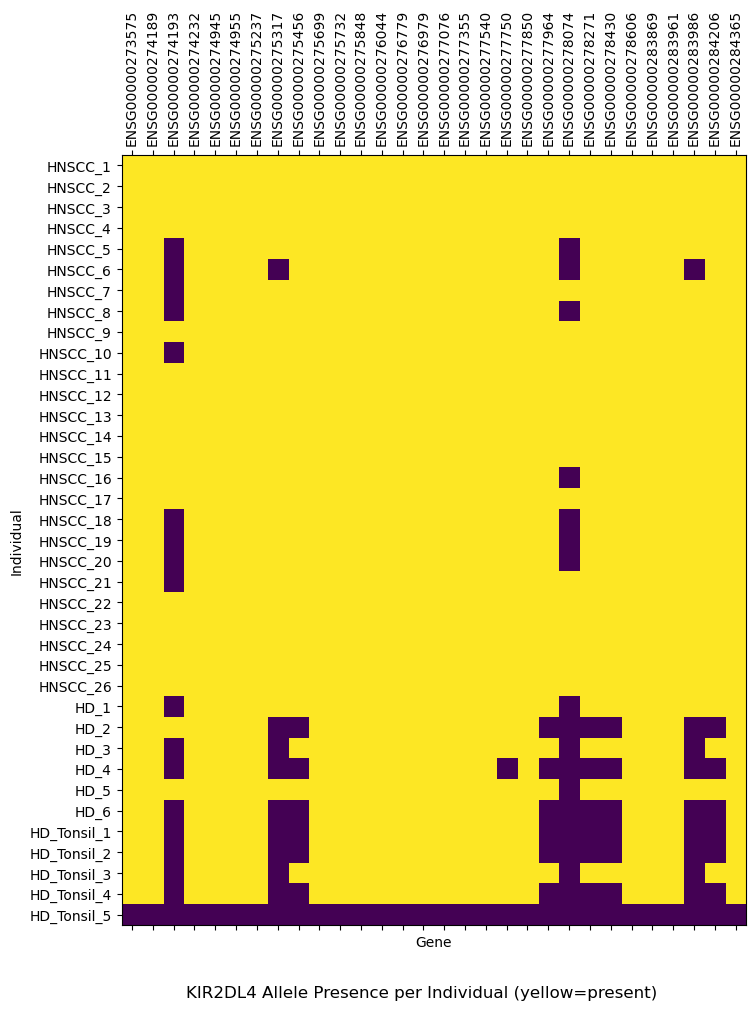

In [17]:
display_variant_presence(adata, "KIR2DL4")
pass

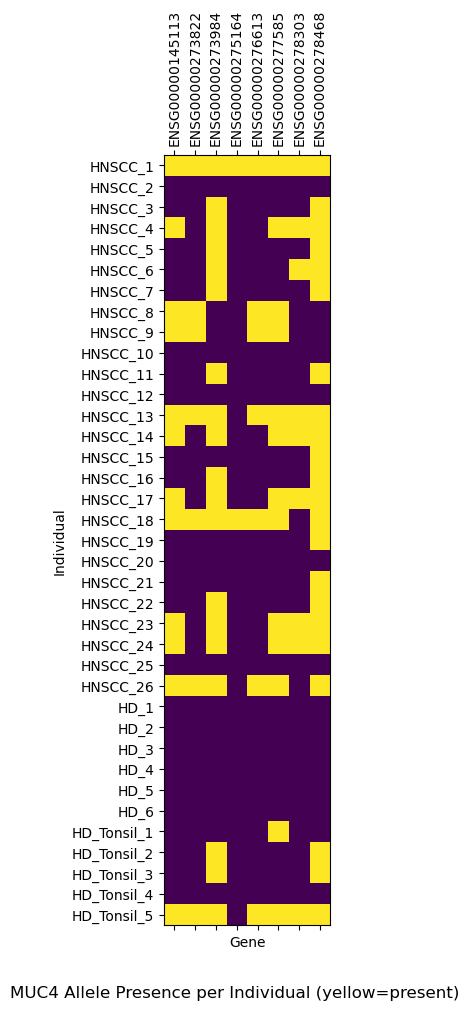

In [18]:
display_variant_presence(adata, "MUC4")
pass

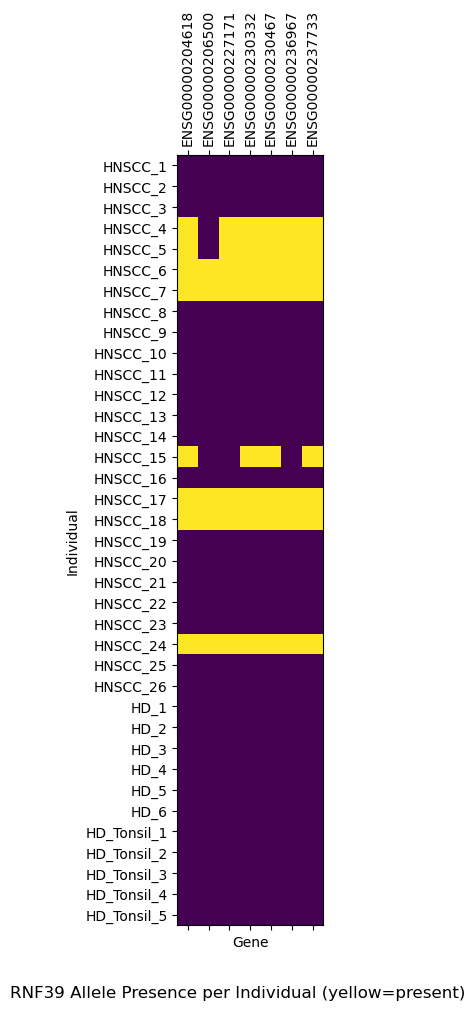

In [19]:
display_variant_presence(adata, "RNF39")
pass

## QC Metrics

From the paper:


>After creation of the gene/barcode matrix, a cell-level filtering step was performed to remove cells with either few genes per cell (<200) or many molecules per cell (>20,000). Next, genes that were lowly expressed (fewer reads than 3 counts in 1% of cells, or genes expressed in fewer than 1% of cells) across all samples were removed.

NOTE: The data is transposed compared to standard format, i.e. it is gene x cell not cell x gene.

Note that we need to filter cells first, then genes (rather than both at once).  Annoyingly, if we index the adata twice, we get the following error:

```
ValueError: Currently, you cannot index repeatedly into a backed AnnData, that is, you cannot make a view of a view.
```

Thus, we need to make a view `fadata` with filtered cells to compute which genes to filter out, but then filter simultaneously on the original `adata` afterwards.

In [20]:
# If we don't do this, Biomart NaN and Not in Biomart will be treated as alleles of the same gene
# which is obviously wrong
adata.obs['external_gene_name_nonan'] = adata.obs['external_gene_name'].copy().astype(str)
idxs = adata.obs['external_gene_name'] == 'Biomart NaN'
adata.obs['external_gene_name_nonan'][idxs] = f"Biomart NaN (" + adata.obs_names[idxs].astype(str) + ")"
idxs = adata.obs['external_gene_name'] == 'Not in Biomart'
adata.obs['external_gene_name_nonan'][idxs] = f"Not in Biomart (" + adata.obs_names[idxs].astype(str) + ")"
adata.obs['external_gene_name_nonan'].value_counts()

KIR3DL2                    30
KIR2DL4                    30
KIR2DL1                    26
KIR2DS4                    26
KIR3DL1                    25
                           ..
PLEKHA6                     1
PPFIA4                      1
ETNK2                       1
SOX13                       1
XNDC1N-ZNF705EP-ALG1L9P     1
Name: external_gene_name_nonan, Length: 23459, dtype: int64

In [21]:
adata.var['gene_count'] = np.array(adata.X[:].sum(axis=0)).flatten()
adata.var['unique_gene_count'] = np.array((adata.X[:] > 0).sum(axis=0)).flatten()

# Remove cells with <200 unique genes per cell
# Remove cells with more than 20,000 reads per cell
filter_cells = (adata.var['unique_gene_count'] >= 200) & (adata.var['gene_count'] <= 20000)

# For the genes, we need to check if they are <1% across all samples
adata.obs['cell_count_fewer_than_three_across_all'] = False
adata.obs['unique_cell_count_across_all'] = False

# Which could mean 1% in each, or, more likely, 1% overall

check_individually = False

if check_individually:
    for idx, sample in enumerate(adata.var['sample'].unique()):
        print(f"Sample {idx + 1} of {adata.var['sample'].unique().shape[0]}")
        fadata = adata[
            :, filter_cells & (adata.var['sample'] == sample)
        ]
        _1percent_cutoff = 0.01 * fadata.shape[1]

        adata.obs['cell_count_fewer_than_three_across_all'] |= (
            np.array((fadata.X[:] >= 3).sum(axis=1) >= _1percent_cutoff).reshape(-1)
        )
        adata.obs['unique_cell_count_across_all'] |= (
            np.array((fadata.X[:] > 0).sum(axis=1) >= _1percent_cutoff).reshape(-1)
        )

    adata.obs['cell_count_fewer_than_three_across_all'] = ~adata.obs['cell_count_fewer_than_three_across_all']
    adata.obs['unique_cell_count_across_all'] = ~adata.obs['unique_cell_count_across_all']
else:
    _1percent_cutoff = 0.01 * adata.shape[1]
    adata.obs['cell_count_fewer_than_three_int'] = (
        np.array((adata.X[:] >= 3).sum(axis=1)).reshape(-1)
    )
    names = (
        adata.obs[
            ['external_gene_name_nonan', 'cell_count_fewer_than_three_int']
        ].groupby('external_gene_name_nonan').sum()
        < _1percent_cutoff
    )
    names = names[names['cell_count_fewer_than_three_int']]
    adata.obs['cell_count_fewer_than_three_across_all'] = adata.obs['external_gene_name_nonan'].isin(names.index)

    adata.obs['unique_cell_count_int'] = (
        np.array((adata.X[:] > 0).sum(axis=1)).reshape(-1)
    )
    names = (
        adata.obs[
            ['external_gene_name_nonan', 'unique_cell_count_int']
        ].groupby('external_gene_name_nonan').sum()
        < _1percent_cutoff
    )
    names = names[names['unique_cell_count_int']]
    adata.obs['unique_cell_count_across_all'] = adata.obs['external_gene_name_nonan'].isin(names.index)



# Remove genes with fewer than three counts in 1% of cells across all samples
# Remove genes expressed in less than 1% of cells across all samples
filter_genes = (
    ~(adata.obs['unique_cell_count_across_all'])
    & ~(adata.obs['cell_count_fewer_than_three_across_all'])
)

padata = adata[filter_genes, filter_cells]

padata

View of AnnData object with n_obs × n_vars = 2200 × 155970 backed at 'out/E-GEOD-139324.h5ad'
    obs: 'external_gene_name', 'external_gene_name_nonan', 'cell_count_fewer_than_three_across_all', 'unique_cell_count_across_all', 'cell_count_fewer_than_three_int', 'unique_cell_count_int'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample', 'gene_count', 'unique_gene_count'

In [22]:
adata.obs['unique_cell_count_across_all']

ENSG00000000003     True
ENSG00000000419    False
ENSG00000000457    False
ENSG00000000460    False
ENSG00000000938    False
                   ...  
ENSG00000289695     True
ENSG00000289697     True
ENSG00000289700     True
ENSG00000289701    False
ENSG00000289716     True
Name: unique_cell_count_across_all, Length: 25184, dtype: bool

In [23]:
# Now remove cells that have 0 genes, and genes that have 0 cells
old_shape = padata.shape
new_shape = None
while old_shape != new_shape:
    old_shape = padata.shape
    filter_cells = np.array((padata.X > 0).sum(axis=0)).flatten() > 0
    filter_genes = np.array((padata.X > 0).sum(axis=1)).flatten() > 0
    padata = padata.to_memory()[filter_genes, filter_cells]
    new_shape = padata.shape

In [24]:
# Here's an example of grouping by allele first
# We could then use these gene names to decide what to keep, thus
# keeping alleles together.
allele_groups = (adata.obs[
    ["cell_count_fewer_than_three_int", "unique_cell_count_int", "external_gene_name"]
].groupby(["external_gene_name"]).sum() >= _1percent_cutoff)

display(allele_groups)
allele_groups.sum(axis=0)

,cell_count_fewer_than_three_int,unique_cell_count_int
external_gene_name,,
5S_rRNA,False,False
A1BG,False,True
A2M,False,True
A2ML1,False,False
A2MP1,False,False
...,...,...
ZYG11A,False,False
ZYG11B,False,True
ZYX,True,True


cell_count_fewer_than_three_int     1982
unique_cell_count_int              11440
dtype: int64

In [25]:
padata

View of AnnData object with n_obs × n_vars = 2200 × 155970
    obs: 'external_gene_name', 'external_gene_name_nonan', 'cell_count_fewer_than_three_across_all', 'unique_cell_count_across_all', 'cell_count_fewer_than_three_int', 'unique_cell_count_int'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample', 'gene_count', 'unique_gene_count'

Text(0.5, 1.0, 'Histogram of unique genes per cell')

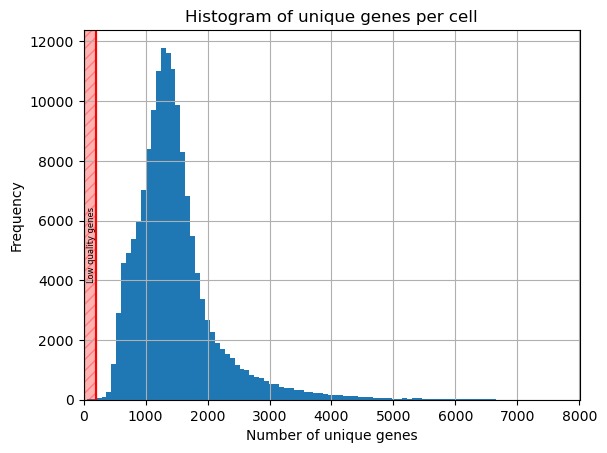

In [26]:
adata.var['unique_gene_count'].hist(bins=100)

# Draw vertical line at 200
plt.axvline(x=200, color='red')

# Draw  rectangle from 0 to 200
plt.axvspan(0, 200, color='red', alpha=0.3, hatch='///')
plt.text(
    50,
    4000,
    "Low quality genes",
    rotation=90,
    fontsize=6,
)

# Limit axis to (0, max)
plt.xlim(0, adata.var['unique_gene_count'].max())

# Label graph
plt.xlabel("Number of unique genes")
plt.ylabel("Frequency")
plt.title("Histogram of unique genes per cell")

Text(0.5, 1.0, 'Histogram of reads per cell')

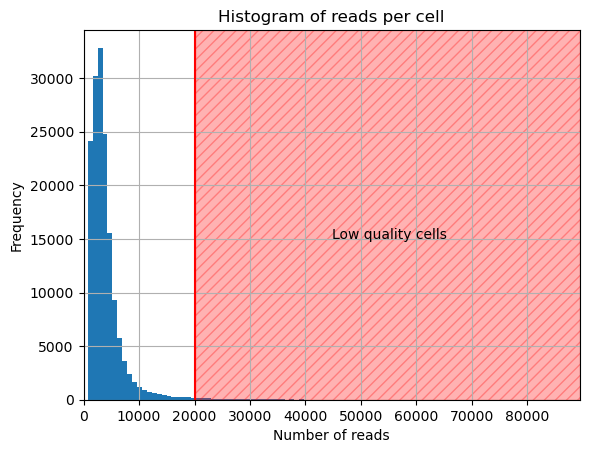

In [27]:
adata.var['gene_count'].hist(bins=100)

# Draw vertical line at 20000
plt.axvline(x=20000, color='red')

# Draw  rectangle from 20000 to max
plt.axvspan(20000, adata.var['gene_count'].max(), color='red', alpha=0.3, hatch='///')
plt.text(
    adata.var['gene_count'].max() // 2,
    15000,
    "Low quality cells",
)

# Limit axis to (0, max)
plt.xlim(0, adata.var['gene_count'].max())

# Label graph
plt.xlabel("Number of reads")
plt.ylabel("Frequency")
plt.title("Histogram of reads per cell")

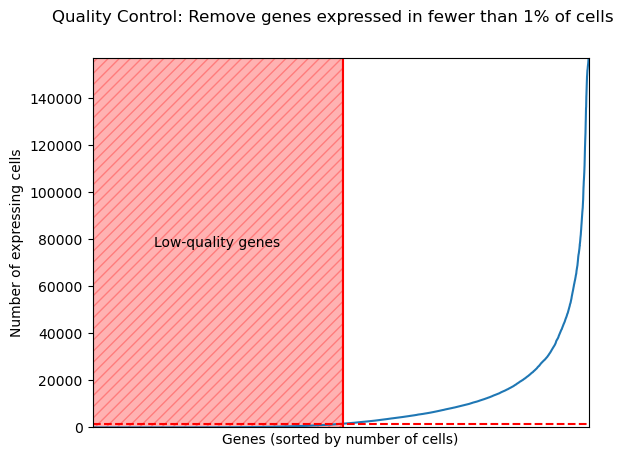

In [28]:
if not check_individually:
    fig, ax = plt.subplots()
    # Draw cumulative plot
    to_plot = adata.obs['unique_cell_count_int'].sort_values()
    to_plot.plot(ax=ax, kind='line')


    # Draw rectangle from 0 to _percent_cutoff
    idx_of_cutoff = to_plot.searchsorted(_1percent_cutoff)
    ax.fill_between(
        to_plot.index[:idx_of_cutoff],
        to_plot.max(),
        color='red',
        alpha=0.3,
        hatch='///'
    )

    # Draw vertical line at _percent_cutoff
    ax.axvline(x=idx_of_cutoff, color='red')
    ax.axhline(y=_1percent_cutoff, color='red', linestyle='--')

    # Add a label to the rectangle
    ax.text(
        idx_of_cutoff // 2,
        to_plot.max() // 2,
        "Low-quality genes",
        horizontalalignment='center',
        verticalalignment='center',
        color='black',
    )

    # Remove x axis ticks
    ax.get_xaxis().set_ticks([])
    ax.set_ylim(0, adata.obs['unique_cell_count_int'].max())
    ax.set_xlim(0, adata.obs['unique_cell_count_int'].shape[0])


    # Label graph
    ax.set_xlabel("Genes (sorted by number of cells)")
    ax.set_ylabel("Number of expressing cells")
    fig.suptitle(r"Quality Control: Remove genes expressed in fewer than 1% of cells")

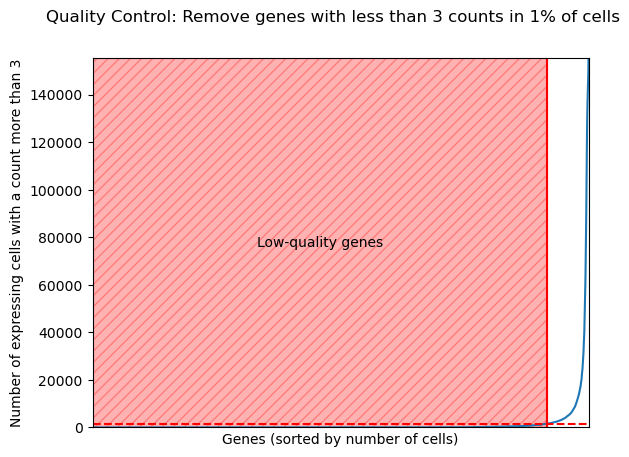

In [29]:
if not check_individually:
    fig, ax = plt.subplots()
    # Draw plot
    to_plot = adata.obs['cell_count_fewer_than_three_int'].sort_values()
    to_plot.plot(ax=ax, kind='line')

    # Draw rectangle from 0 to _percent_cutoff
    idx_of_cutoff = to_plot.searchsorted(_1percent_cutoff)
    ax.fill_between(
        to_plot.index[:idx_of_cutoff],
        to_plot.max(),
        color='red',
        alpha=0.3,
        hatch='///'
    )

    # Draw vertical line at _percent_cutoff
    ax.axvline(x=idx_of_cutoff, color='red')
    ax.axhline(y=_1percent_cutoff, color='red', linestyle='--')

    # Add a label to the rectangle
    ax.text(
        idx_of_cutoff // 2,
        to_plot.max() // 2,
        "Low-quality genes",
        horizontalalignment='center',
        verticalalignment='center',
        color='black',
    )

    # Remove x axis ticks
    ax.get_xaxis().set_ticks([])
    ax.set_ylim(0, adata.obs['cell_count_fewer_than_three_int'].max())
    ax.set_xlim(0, adata.obs['cell_count_fewer_than_three_int'].shape[0])


    # Label graph
    ax.set_xlabel("Genes (sorted by number of cells)")
    ax.set_ylabel("Number of expressing cells with a count more than 3")
    fig.suptitle(r"Quality Control: Remove genes with less than 3 counts in 1% of cells")

In [30]:
filtered_genes = padata.obs['external_gene_name']
filt_vc = filtered_genes.value_counts()
new_variants = filt_vc[
    (filt_vc > 1)
    & (filt_vc.index != "Not in Biomart")
    & (filt_vc.index != "Biomart NaN")
]
not_in_biomart_genes = filtered_genes[filtered_genes == "Not in Biomart"]
biomart_nan_genes = filtered_genes[filtered_genes == "Biomart NaN"]
variant_genes = filtered_genes[filtered_genes.isin(new_variants.index)]
other_genes = filtered_genes[
    ~filtered_genes.isin(variant_genes.values)
    & (filtered_genes != "Not in Biomart")
    & (filtered_genes != "Biomart NaN")
]
print(f"Genes not in biomart: {not_in_biomart_genes.shape[0]}")
print(f"Genes with NaN in biomart: {biomart_nan_genes.shape[0]}")
print(f"Genes with variants: {variant_genes.shape[0]}")
print(f"Other genes: {other_genes.shape[0]}")

# For later use - includes genes that used to be considered variants, but now may be
# singletons due to our filtering step
old_variant_genes = filtered_genes[filtered_genes.isin(variants.index)]

Genes not in biomart: 7
Genes with NaN in biomart: 23
Genes with variants: 277
Other genes: 1893


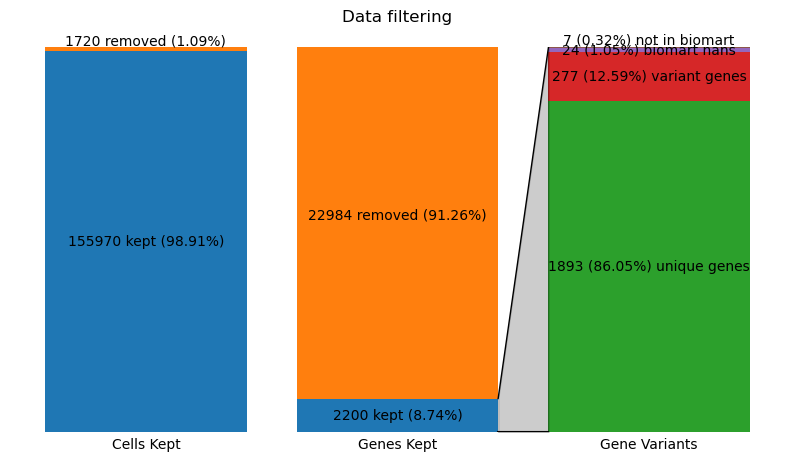

In [31]:
gene_full, cell_full = adata.shape
gene_filt, cell_filt = padata.shape

# Draw a stacked bar plot with this data
fig, ax = plt.subplots(figsize=(10, 5))
bottom_gene = gene_filt/gene_full
bottom_cell = cell_filt/cell_full
b1 = ax.bar(
    ["Cells Kept", "Genes Kept"],
    [bottom_cell, bottom_gene],
    label="Full",
)
b2 = ax.bar(
    ["Cells Kept", "Genes Kept"],
    [(cell_full-cell_filt)/cell_full, (gene_full-gene_filt)/gene_full],
    label="Filtered",
    bottom=[bottom_cell, bottom_gene],
)
ax.bar_label(b1, label_type='center', labels=[
    f"{math.ceil(x.get_height() * (gene_full if idx == 1 else cell_full))} kept ({x.get_height():.2%})"
    for idx, x in enumerate(b1)
])
ax.bar_label(b2, label_type='center', labels=[
    f"{math.ceil(x.get_height() * (gene_full if idx == 1 else cell_full))} removed ({x.get_height():.2%})\n"
    for idx, x in enumerate(b2)
])

cur_bottom = 0
for name, geneset in [
    ("unique genes", other_genes),
    ("variant genes", variant_genes),
    ("biomart nans", biomart_nan_genes),
    ("not in biomart\n", not_in_biomart_genes)
]:
    next_bottom = geneset.shape[0]/gene_filt
    b3 = ax.bar(
        ["Gene Variants"],
        [next_bottom],
        label="Variant",
        bottom=[cur_bottom],
    )
    ax.bar_label(b3, label_type='center', labels=[
        f"{math.ceil(x.get_height() * gene_filt)} ({x.get_height():.2%}) {name}"
        for x in b3
    ])
    cur_bottom += next_bottom

ax.set_ylim(0, 1)

# Remove axis frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove ticks
ax.tick_params(axis='y', length=0)
ax.tick_params(axis='x', length=0)

# Remove labels
ax.set_yticklabels([])

# Add title
ax.set_title("Data filtering\n")

# Connect bottom "genes kept" bar to the "variant genes" bars
ax.plot(
    [b1[1].get_x() + b1[1].get_width(), b3[0].get_x()],
    [b1[1].get_height(), 1],
    color='black',
    linewidth=1
)
ax.plot(
    [b1[1].get_x() + b1[1].get_width(), b3[0].get_x()],
    [0, 0],
    color='black',
)
ax.fill_between(
    [b1[1].get_x() + b1[1].get_width(), b3[0].get_x()],
    [b1[1].get_height(), 1],
    [0, 0],
    color='black',
    alpha=0.2,
)

pass

Text(43.0, 4.25, 'No longer duplicates')

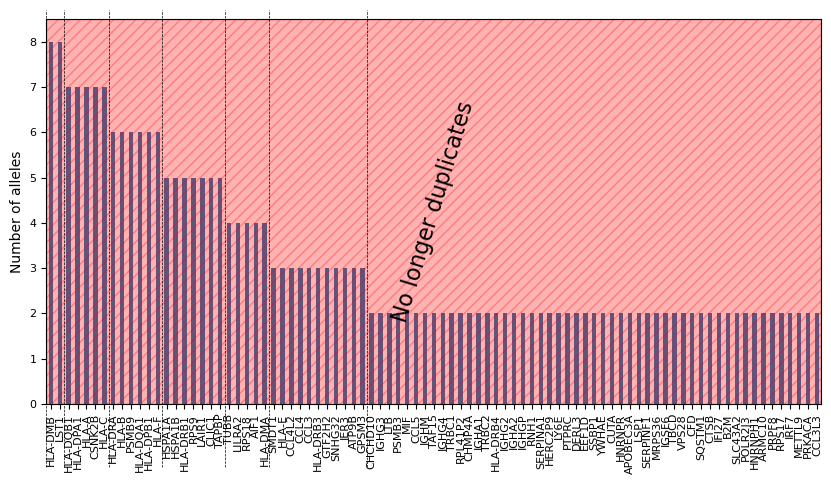

In [32]:
# What are the variant genes that are kept?
fig, ax = plt.subplots(figsize=(10, 5))
var_valcounts = old_variant_genes.value_counts()
var_valcounts.plot(kind='bar', rot=90, ylabel='count', fontsize=8, ax=ax)
top = var_valcounts.max() + 0.5
ax.set_ylim(0, top)
ax.set_ylabel("Number of alleles")

# Draw a vertical line every time there is a change in value
prev_value = 0
singleton_location = 0
for idx, value in enumerate(var_valcounts.values):
    if value != prev_value:
        ax.plot([idx-0.5, idx-0.5], [-1.4, top+0.2], color='black', linewidth=0.5, linestyle='--', clip_on=False)
        prev_value = value
        if value == 1:
            singleton_location = idx

# Draw a rectangle covering everything that is now a singleton due to its alleles being removed
ax.axvspan(singleton_location-0.5, idx+0.5, color='red', alpha=0.3, hatch='///')

# Label this box
ax.text(
    (singleton_location + idx) / 2,
    top*0.5,
    "No longer duplicates",
    fontsize=16,
    ha='center',
    va='center',
    rotation=73,
)

Text(0, 0.5, 'Number of alleles')

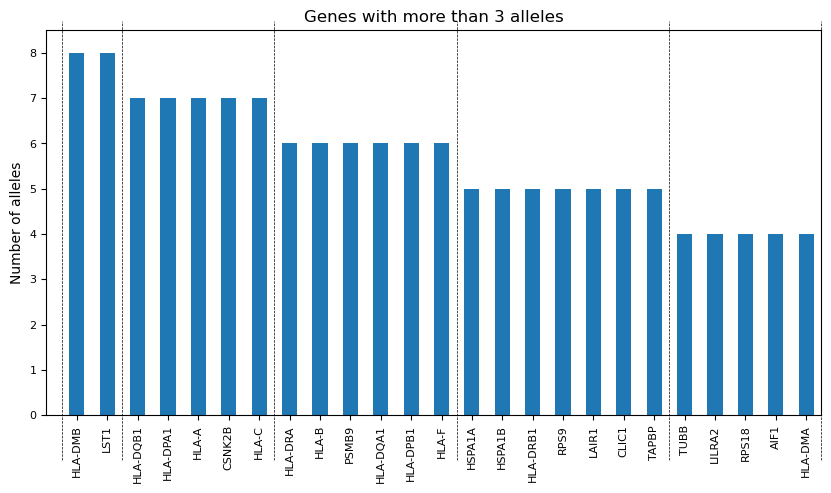

In [33]:
cutoff = 3

# What are the variant genes that are kept?
fig, ax = plt.subplots(figsize=(10, 5))
var_valcounts = old_variant_genes.value_counts()
var_valcounts.plot(kind='bar', rot=90, ylabel='count', fontsize=8, ax=ax)
top = var_valcounts.max() + 0.5
ax.set_ylim(0, top)

# Draw a vertical line every time there is a change in value
prev_value = 0
cutoff_location = 0
for idx, value in enumerate(var_valcounts.values):
    if value != prev_value:
        ax.plot([idx-0.5, idx-0.5], [-1, top+0.2], color='black', linewidth=0.5, linestyle='--', clip_on=False)
        prev_value = value
        if value == cutoff:
            singleton_location = idx
            break

ax.set_xlim(-1, idx-0.5)
ax.set_title(f"Genes with more than {cutoff} alleles")
ax.set_ylabel("Number of alleles")

In [34]:
out = ""
hlas = list(
    set(adata.obs['external_gene_name'][adata.obs['external_gene_name'].str.startswith("HLA")])
)
hlas.sort()
for idx, x in enumerate(hlas):
    out += f"{x}   \t"
    if idx % 5 == 4:
        out += "\n"
print(out)

HLA-A   	HLA-B   	HLA-C   	HLA-DMA   	HLA-DMB   	
HLA-DOA   	HLA-DOB   	HLA-DPA1   	HLA-DPA2   	HLA-DPB1   	
HLA-DPB2   	HLA-DQA1   	HLA-DQA2   	HLA-DQB1   	HLA-DQB2   	
HLA-DRA   	HLA-DRB1   	HLA-DRB2   	HLA-DRB3   	HLA-DRB4   	
HLA-DRB5   	HLA-DRB6   	HLA-DRB7   	HLA-DRB8   	HLA-E   	
HLA-F   	HLA-G   	HLA-H   	HLA-J   	HLA-K   	
HLA-L   	HLA-U   	HLA-V   	


# UMAP Sanity Check

In [35]:
def transpose(adata: ad.AnnData) -> ad.AnnData:
        """
        Copied and modified from the AnnData project
        to work with their experimental CSRDataset
        """
        from anndata.compat import _safe_transpose

        if not adata.isbacked:
            X = adata.X
        else:
            X = adata.file["X"]
        if adata.is_view:
            raise ValueError(
                "You’re trying to transpose a view of an `AnnData`, "
                "which is currently not implemented. Call `.copy()` before transposing."
            )

        return ad.AnnData(
            X=adata.X[:].T if X is not None else None,
            layers={k: _safe_transpose(v) for k, v in adata.layers.items()},
            obs=adata.var,
            var=adata.obs,
            uns=adata._uns,
            obsm=adata._varm,
            varm=adata._obsm,
            obsp=adata._varp,
            varp=adata._obsp,
        )

bdata = transpose(adata.to_memory())

In [36]:
sc.pp.log1p(bdata)
sc.pp.pca(bdata)
sc.pp.neighbors(bdata, n_pcs=50)
sc.tl.umap(bdata,random_state=0)

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


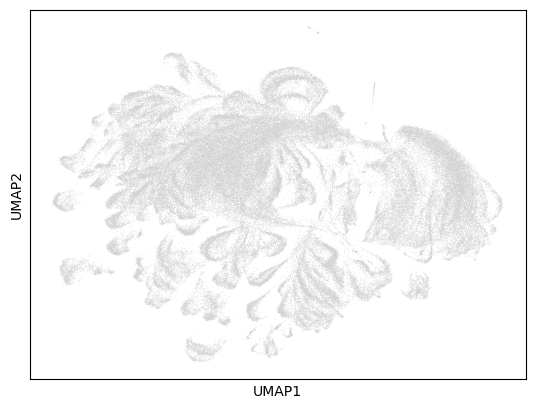

In [37]:
sc.pl.umap(bdata, ncols=1)

In [38]:
pbdata = transpose(padata.to_memory())

In [39]:
sc.pp.neighbors(pbdata, n_pcs=50)
sc.tl.umap(pbdata,random_state=0)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


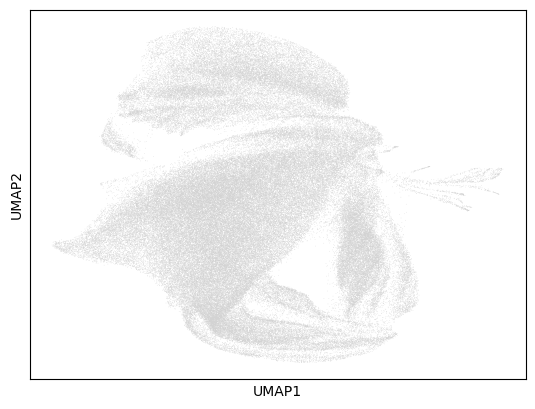

In [40]:
sc.pl.umap(pbdata, ncols=1)

In [41]:
pcatest = padata.to_memory()
sc.pp.log1p(pcatest)
sc.pp.pca(pcatest)

Text(0.5, 1.0, 'Explained variance of filtered dataset (genes)')

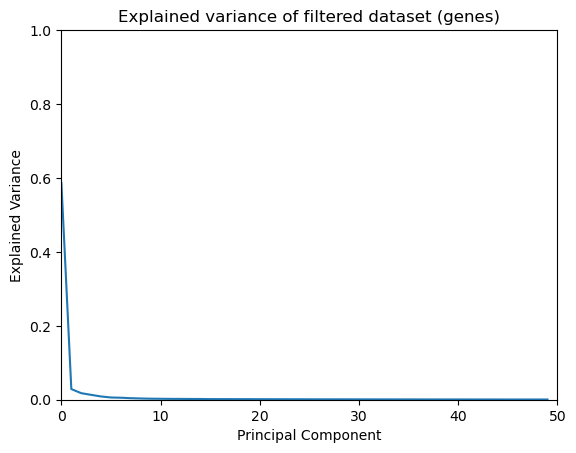

In [42]:
# This graph gives us some idea as to what the explained variance might look like
# when we run GmGM (but of course there is preprocessing, so it will be different)

fig, ax = plt.subplots()

explained_variance = pcatest.uns['pca']['variance_ratio']
ax.plot(explained_variance)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance")

ax.set_xlim(0, 50)
ax.set_ylim(0, 1)

ax.set_title("Explained variance of filtered dataset (genes)")

# Create the Graph

In [43]:
dataset = GmGM.Dataset(
    dataset={"data": padata.X[:, :]},
    structure={"data": ("gene", "cell")}
)
dataset

output = GmGM.GmGM(
    dataset,
    # to_keep=10,
    # threshold_method="overall-col-weighted",
    threshold_method="bonferroni",
    to_keep=0.05,
    min_edges={"cell": 5, "gene": 0},
    n_comps=1000,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=True,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    #_assume_sparse=True,
    batch_size=1000
)

Centering...
Calculating eigenvectors...
	by calculating left eigenvectors and applying a rank-one update...
		Computing sparse normal map for axis='gene'...
		...Done computing sparse normal map
		Explained variance for axis='gene': 91.2020%
		Computing sparse normal map for axis='cell'...
		...Done computing sparse normal map
		Explained variance for axis='cell': 88.9172%
Calculating eigenvalues...
@0: 321117219.9551501 (-693400.4643875408 + 321810620.41953766 + 0) ∆inf
Converged! (@13: 249551350.22729263)
Recomposing sparse precisions...


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


Gene cutoff: 1.3449197798147352, Cell cutoff: 52.729027018387356


(0.0, 1001.0)

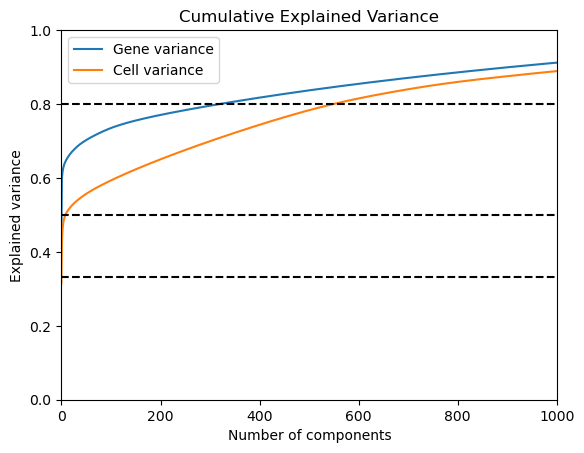

In [44]:
fig, ax = plt.subplots()

# Plot cumulative eigenvalues
ax.plot((output.es['gene'] / output.total_variance['gene']).cumsum(), label="Gene variance")
ax.plot((output.es['cell'] / output.total_variance['cell']).cumsum(), label="Cell variance")
ax.set_title("Cumulative Explained Variance")
ax.legend()
ax.set_xlabel("Number of components")
ax.set_ylabel("Explained variance")

# Explained variance cutoff
ax.axhline(1/3, color='k', linestyle='--')
ax.axhline(1/2, color='k', linestyle='--')
ax.axhline(0.8, color='k', linestyle='--')

# Note that formula is variance * (1 +- #genes/#cells)^2 [in the limit!], if data is genes x cells
# but it was mapped to standard normal distribution so variance=1, and since variance should be 1
# it should be a correlation matrix and hence the "in the limit" part is not necessary
# Of course, this assumes independent samples and dependent features, whereas we assume dependence
# in both.  However it forms a good test.
gene_cutoff = (1 + adata.X.shape[0] / adata.X.shape[1]) ** 2
cell_cutoff = (1 + adata.X.shape[1] / adata.X.shape[0]) ** 2

# Find first element in output.es['gene'] less than the gene cutoff and same for cells
gene_cutoff_idx = np.where((output.es['gene'] / output.total_variance['gene']).cumsum() < gene_cutoff)[0][-1]
cell_cutoff_idx = np.where((output.es['cell'] / output.total_variance['cell']).cumsum() < cell_cutoff)[0][-1]
print(f"Gene cutoff: {gene_cutoff}, Cell cutoff: {cell_cutoff}")

# Make vertical line
if gene_cutoff_idx < cell_cutoff_idx:
    if gene_cutoff_idx < output.es['gene'].shape[0]-1:
        ax.axvline(gene_cutoff_idx, color='r', linestyle='--')
else:
    if cell_cutoff_idx < output.es['cell'].shape[0]-1:
        ax.axvline(cell_cutoff_idx, color='r', linestyle='--')

ax.set_ylim(0, 1)
ax.set_xlim(0, output.es['gene'].shape[0])

In [45]:
# Get point that gene variance crosses 50% threshold:
try:
    gene_var_idx = np.where((output.es['gene'] / output.total_variance['gene']).cumsum() > 0.5)[0][0]
except:
    gene_var_idx = "[DOESN'T]"
try:
    cell_var_idx = np.where((output.es['cell'] / output.total_variance['cell']).cumsum() > 0.5)[0][0]
except:
    cell_var_idx = "[DOESN'T]"
print(
    f"Gene variance crosses 50% threshold at {gene_var_idx} components\n"
    + f"Cell variance crosses 50% threshold at {cell_var_idx} components"
)

Gene variance crosses 50% threshold at 1 components
Cell variance crosses 50% threshold at 9 components


In [46]:
# # make a scree plot
# fig, ax = plt.subplots()

# for eval_type in ['gene', 'cell']:
#     scaled_evals = (output.es[eval_type] / output.es[eval_type].max())

#     ax.plot(np.linspace(0, 1, len(scaled_evals)), scaled_evals, label=eval_type)

#     # Find places where the slope changes from >-1 to <-1
#     slope = np.diff(scaled_evals) / (1 / len(scaled_evals))

#     # Find the first place where the slope is less than -1
#     slope_idcs = np.where(slope > -1)[0]
#     candidates = slope_idcs[:-1][np.diff(slope_idcs) > 1]

#     # Draw an x marker at (x, y)
#     for candidate in [candidates[len(candidates)//2+1]]:
#         x = candidate / len(scaled_evals)
#         y = scaled_evals[candidate]
#         ax.scatter(x, y, marker='x', color='k')

#         if eval_type == "gene":
#             # Add a label at (x, y)
#             ax.text(
#                 x+0.02,
#                 y,
#                 f"{candidate + 1} principal components",
#                 fontsize=8,
#                 ha='left',
#             )
#         elif eval_type == "cell":
#             # Add a label at (x, y)
#             ax.text(
#                 x-0.065,
#                 y-0.165,
#                 f"{candidate + 1} principal\ncomponents",
#                 fontsize=8,
#                 ha='left',
#                 rotation=-45
#             )

#         # Draw a line with slope -1 passing through (x, y)
#         ax.plot([x, x+y], [y, 0], color='k', linestyle='--')
#         ax.plot([x, 0], [y, y+x], color='k', linestyle='--')


# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)

# ax.set_xlabel("Principal components, normalized to a scale of 0 to 1")
# ax.set_ylabel("Eigenvalues, normalized to a scale of 0 to 1")
# ax.set_title("Scree plot to pick the amount of eigenvalues")

# ax.legend()

# # Make it square
# ax.set_box_aspect(1)


In [47]:
padata

View of AnnData object with n_obs × n_vars = 2200 × 155970
    obs: 'external_gene_name', 'external_gene_name_nonan', 'cell_count_fewer_than_three_across_all', 'unique_cell_count_across_all', 'cell_count_fewer_than_three_int', 'unique_cell_count_int'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample', 'gene_count', 'unique_gene_count'

# Save

Trying to assign precision matrices gives an error to a view of a backed adata, annoyingly!

In [48]:
tosave = padata.to_memory()
tosave

AnnData object with n_obs × n_vars = 2200 × 155970
    obs: 'external_gene_name', 'external_gene_name_nonan', 'cell_count_fewer_than_three_across_all', 'unique_cell_count_across_all', 'cell_count_fewer_than_three_int', 'unique_cell_count_int'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample', 'gene_count', 'unique_gene_count'

In [49]:
# Add the precision matrices - only allowed to store them in the 'matrix' class
tosave.obsp['gene'] = sparse.csr_matrix(output.precision_matrices['gene'])
tosave.varp['cell'] = sparse.csr_matrix(output.precision_matrices['cell'])

In [50]:
# Preempt the 'TypeError: Can't implicitly convert non-string objects to strings' error
for column in tosave.var.columns:
    if tosave.var[column].dtype == 'O':
        tosave.var[column] = tosave.var[column].astype('category')

In [51]:
tosave.write("out/min-5-pcs-1000-E-GEOD-139324.h5ad")

# Less PCs

In [52]:
dataset = GmGM.Dataset(
    dataset={"data": padata.X[:, :]},
    structure={"data": ("gene", "cell")}
)
dataset

output2 = GmGM.GmGM(
    dataset,
    #to_keep=10,
    #threshold_method="overall-col-weighted",
    threshold_method="bonferroni",
    to_keep=0.05,
    min_edges={"cell": 5, "gene": 0},
    n_comps=50,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=True,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    #_assume_sparse=True,
    batch_size=1000
)

Centering...
Calculating eigenvectors...
	by calculating left eigenvectors and applying a rank-one update...
		Computing sparse normal map for axis='gene'...
		...Done computing sparse normal map
		Explained variance for axis='gene': 70.1832%
		Computing sparse normal map for axis='cell'...
		...Done computing sparse normal map
		Explained variance for axis='cell': 55.6117%
Calculating eigenvalues...
@0: 196900711.3536201 (-1760.8814225637102 + 196902472.23504266 + 0) ∆inf
Converged! (@13: 125423145.14368322)
Recomposing sparse precisions...


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


In [53]:
tosave = padata.to_memory()
tosave

AnnData object with n_obs × n_vars = 2200 × 155970
    obs: 'external_gene_name', 'external_gene_name_nonan', 'cell_count_fewer_than_three_across_all', 'unique_cell_count_across_all', 'cell_count_fewer_than_three_int', 'unique_cell_count_int'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample', 'gene_count', 'unique_gene_count'

In [54]:
# Add the precision matrices - only allowed to store them in the 'matrix' class
tosave.obsp['gene'] = sparse.csr_matrix(output2.precision_matrices['gene'])
tosave.varp['cell'] = sparse.csr_matrix(output2.precision_matrices['cell'])

In [55]:
# Preempt the 'TypeError: Can't implicitly convert non-string objects to strings' error
for column in tosave.var.columns:
    if tosave.var[column].dtype == 'O':
        tosave.var[column] = tosave.var[column].astype('category')

In [56]:
tosave.write("out/min-5-pcs-50-E-GEOD-139324.h5ad")